In [1]:
!python -m pip install --upgrade tensorflow-probability
import tensorflow as tf
import numpy as np
from numpy import save
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle
from IPython.display import Image

import tensorflow_probability as tfp
import tensorflow_probability.python.distributions as tfd
import tensorflow_probability.python.layers as tfpl

#!python -m pip install git+https://github.com/mwaskom/seaborn.git
#import seaborn as sns
#sns.set(rc={'figure.figsize':(11.7,8.27)})

import json
!python -m pip install batchup
from batchup import data_source
from collections import Counter
from sklearn.cluster import KMeans, SpectralClustering

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: tensorflow-probability in /home/ssbose/.local/lib/python3.7/site-packages (0.10.0)
Defaulting to user installation because normal site-packages is not writeable


## Step 1: Loading the datasets

In [2]:
X_train = np.load('/datasets/home/21/321/ee228sp20ta1/G51/train_set.npy')
X_valid = np.load('/datasets/home/21/321/ee228sp20ta1/G51/val_set.npy')

## Step 2: Scaling and reshaping the datasets

In [3]:
x_train = X_train[:,:,:216].copy()
x_train = x_train.reshape((X_train.shape[0]*X_train.shape[1],216))

x_valid = X_valid[:,:,:216].copy()
x_valid = x_valid.reshape((X_valid.shape[0]*X_valid.shape[1],216))

print(x_train.shape)
print(x_valid.shape)

scaler = MinMaxScaler().fit(x_train) 
scaled_train = scaler.transform(x_train)
scaled_valid = scaler.transform(x_valid)

s_train_reshaped = scaled_train.reshape(15001,96,216,1)
s_valid_reshaped = scaled_valid.reshape(2763,96,216,1)

(1440096, 216)
(265248, 216)


In [4]:
del X_train, X_valid, x_train, x_valid, scaled_train, scaled_valid

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((s_train_reshaped, s_train_reshaped))
valid_dataset = tf.data.Dataset.from_tensor_slices((s_valid_reshaped, s_valid_reshaped))

In [6]:
del s_train_reshaped

## Step 3: Shuffling and splitting the dataset into batches for training

In [7]:
BATCH_SIZE = 15
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)

## Step 4: Defining the number of latent dimensions and generating the prior distribution

In [8]:
encoded_size = 16 # dimensions of latent state
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),reinterpreted_batch_ndims=1)

## Step 5: Defining the architecture for the VAE

In [9]:
encoder = keras.Sequential([
    #layers.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    layers.Conv2D(96, 3, padding="same", activation = 'relu', input_shape = (96, 216, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(45, 3, padding="same",  activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), padding='same',  activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size)),
    tfpl.MultivariateNormalTriL(encoded_size, activity_regularizer = tfpl.KLDivergenceRegularizer(prior, weight = 1.0)),
])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [44]:
## Run this cell if you need to review the encoder layer by layer
for layer in encoder.layers:
    print (layer)
    if (type(layer.output) is tuple):
        print (layer.output[0].shape, layer.output[1].shape)
    else:
        print (layer.output.shape)

(None, 96, 216, 96)
(None, 48, 108, 96)
(None, 48, 108, 45)
(None, 24, 54, 45)
(None, 24, 54, 16)
(None, 12, 27, 16)
(None, 5184)
(None, 152)
(None, 16) (None, 16)


In [10]:
decoder = keras.Sequential([
    layers.Input(shape = [encoded_size]),
    layers.Reshape((1, 1, encoded_size)),
    layers.Conv2DTranspose(16, 3, padding='valid',  activation = 'relu'),
    layers.UpSampling2D(size=(2,3)),
    layers.Conv2DTranspose(45, 3, padding='same',  activation = 'relu'),
    layers.UpSampling2D(size=(2,1)),
    layers.Conv2DTranspose(96, 3, padding='same',  activation = 'relu'),
    layers.UpSampling2D(size=(2,1)),
    layers.Flatten(),
    #layers.Reshape((96, 216, 1)),
    #layers.Conv2DTranspose(1, 3, activation = 'sigmoid', padding = 'same'),
    tfpl.IndependentBernoulli((96, 216, 1), tfd.Bernoulli.logits)
])

In [48]:
## Run this cell if you wish to review the decoder layer by layer
for layer in decoder.layers:
    print (layer)
    if (type(layer.output) is tuple):
        print (layer.output[0].shape, layer.output[1].shape)
    else:
        print (layer.output.shape)

(None, 1, 1, 16)
(None, 3, 3, 16)
(None, 6, 9, 16)
(None, 6, 9, 45)
(None, 12, 9, 45)
(None, 12, 9, 96)
(None, 24, 9, 96)
(None, 20736)
(None, 96, 216, 1) (None, 96, 216, 1)


## Step 6: Compile the VAE

In [11]:
vae = keras.Model(inputs=encoder.inputs,outputs=decoder(encoder.outputs[0]))
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-4), loss=negative_log_likelihood)

## Step 7: Training (and validating) the VAE

In [12]:
history = vae.fit(train_dataset, batch_size = 5, epochs = 125, validation_data = (valid_dataset), shuffle = True)

Epoch 1/125
1001/1001 [==============================] - 31s 31ms/step - loss: 13927.9316 - val_loss: 13900.8672
Epoch 2/125
1001/1001 [==============================] - 31s 31ms/step - loss: 13897.9570 - val_loss: 13888.7295
Epoch 3/125
1001/1001 [==============================] - 31s 31ms/step - loss: 13894.8330 - val_loss: 13876.6250
Epoch 4/125
1001/1001 [==============================] - 31s 31ms/step - loss: 13892.8174 - val_loss: 13891.0664
Epoch 5/125
1001/1001 [==============================] - 30s 30ms/step - loss: 13890.0488 - val_loss: 13871.7627
Epoch 6/125
1001/1001 [==============================] - 31s 31ms/step - loss: 13888.3018 - val_loss: 13871.1201
Epoch 7/125
1001/1001 [==============================] - 31s 31ms/step - loss: 13887.5674 - val_loss: 13870.9258
Epoch 8/125
1001/1001 [==============================] - 30s 30ms/step - loss: 13887.1045 - val_loss: 13873.3721
Epoch 9/125
1001/1001 [==============================] - 30s 30ms/step - loss: 13886.7891 - val_

Epoch 73/125
1001/1001 [==============================] - 28s 28ms/step - loss: 13879.9727 - val_loss: 13866.1240
Epoch 74/125
1001/1001 [==============================] - 28s 28ms/step - loss: 13879.9795 - val_loss: 13862.7363
Epoch 75/125
1001/1001 [==============================] - 28s 28ms/step - loss: 13879.8535 - val_loss: 13865.6543
Epoch 76/125
1001/1001 [==============================] - 29s 29ms/step - loss: 13879.8096 - val_loss: 13862.9199
Epoch 77/125
1001/1001 [==============================] - 28s 28ms/step - loss: 13879.8945 - val_loss: 13862.8408
Epoch 78/125
1001/1001 [==============================] - 28s 28ms/step - loss: 13879.7412 - val_loss: 13863.0166
Epoch 79/125
1001/1001 [==============================] - 28s 28ms/step - loss: 13879.7666 - val_loss: 13862.5811
Epoch 80/125
1001/1001 [==============================] - 28s 28ms/step - loss: 13879.6904 - val_loss: 13862.8447
Epoch 81/125
1001/1001 [==============================] - 28s 28ms/step - loss: 13879.68

## Step 8: Plotting the losses

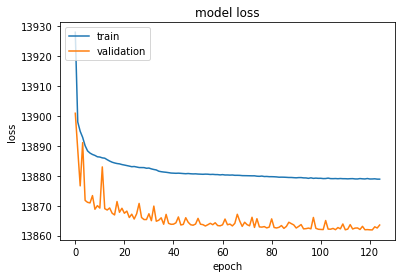

<Figure size 432x288 with 0 Axes>

In [13]:
#Plot train/validation loss vs epoch

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.savefig('VAE085_epochs125.png')

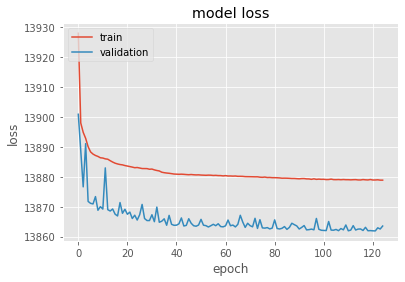

In [23]:
plt.style.use('ggplot')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Step 9: Saving the (weights of the) model and the training history

In [17]:
import os
cwd = os.getcwd()
models_path = '/models-vae/model_085/'
vae.save_weights(cwd+models_path+'vae_085')

In [18]:
with open(cwd+models_path+'/VAE_085_trainHistoryDict.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Step 10: Visualize encoder-latent space-decoder

In [14]:
mini_batch = s_valid_reshaped[:100]
#print(mini_batch.shape)

decoded_data = vae.predict(valid_dataset)
#Obtain encoder representation of data
get_hl = K.function([vae.layers[0].input], [vae.layers[5].output])
AE_h1 = get_hl([mini_batch])[0]
print (AE_h1[0].shape)

(24, 54, 16)


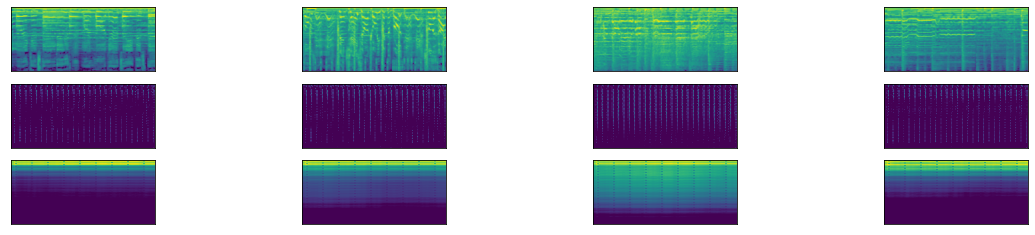

In [15]:
#Plot samples of input images, their hidden layer representations, and their reconstructions
n = 4  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(s_valid_reshaped[i].reshape(96, 216))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display hidden layer representation
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(AE_h1[i].reshape(96, 216)) # Will have to reshape if you change the latent dimensionality
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_data[i].reshape(96, 216))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
plt.savefig('LatentRepresentationsVAE_08')

<Figure size 432x288 with 0 Axes>

## Community Detection based on Autoencoder results

### Step 1: Loading in Community Labels

In [24]:
with open('val_communities_3.json') as json_file:
    community_labels = json.load(json_file)

In [25]:
val_set = s_valid_reshaped

In [26]:
val_ids_path = '/datasets/home/21/321/ee228sp20ta1/G51/val_ids.txt'

### Step 2: Loading in IDs of songs in the validation set

In [27]:
f=open(val_ids_path, "r")
val_spec_ids = f.read()
val_spec_labels = val_spec_ids.split('\n')
# type(val_spec_labels)

In [28]:
import os
cwd = os.getcwd()

### Step 3: Loading in the weights of the VAE

In [29]:
models_path = '/models-vae/model_085/'
vae.load_weights(cwd+models_path+'vae_085')

### Step 4: Create batches of validation spectrograms

In [30]:
ds = data_source.ArrayDataSource([val_set])

latent_vecs = []

get_hl = K.function([vae.layers[0].input], [vae.layers[5].output])

for batch in ds.batch_iterator(batch_size=64, shuffle=False):
    
    AE_h1 = get_hl([batch])[0]
    latent_vecs.append(AE_h1)
    
latent_vecs = np.array(latent_vecs)

latent_vecs = np.concatenate(latent_vecs)
#print(latent_vecs.shape)

In [31]:
latent_vectors = np.ndarray(shape=(2763,96,216))

for idx, spec in enumerate(val_set):
    latent_vec = latent_vecs[idx].reshape(96, 216)
    latent_vectors[idx] = latent_vec
    
# print(latent_vectors.shape)

In [32]:
reshaped_latent_vectors = latent_vectors.reshape(2763,latent_vectors.shape[1] * latent_vectors.shape[2])

### Step 5: Run K-means clustering

In [33]:
kmeans = KMeans(n_clusters=3, init='random', verbose =1).fit(reshaped_latent_vectors)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 757.2806427246851
start iteration
done sorting
end inner loop
Iteration 1, inertia 691.5636928721779
start iteration
done sorting
end inner loop
Iteration 2, inertia 682.2276564132646
start iteration
done sorting
end inner loop
Iteration 3, inertia 679.8592692632355
start iteration
done sorting
end inner loop
Iteration 4, inertia 678.4695102145861
start iteration
done sorting
end inner loop
Iteration 5, inertia 677.3232502385213
start iteration
done sorting
end inner loop
Iteration 6, inertia 676.5393377600429
start iteration
done sorting
end inner loop
Iteration 7, inertia 676.1317680355205
start iteration
done sorting
end inner loop
Iteration 8, inertia 675.9613552986456
start iteration
done sorting
end inner loop
Iteration 9, inertia 675.8588945233694
start iteration
done sorting
end inner loop
Iteration 10, inertia 675.7888127279416
start iteration
done sorting
end inner loop
Iteration 11, iner

Iteration 6, inertia 675.7785968204839
start iteration
done sorting
end inner loop
Iteration 7, inertia 675.7616697395895
start iteration
done sorting
end inner loop
Iteration 8, inertia 675.7616697395895
center shift 0.000000e+00 within tolerance 1.933732e-09
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 708.3821269195904
start iteration
done sorting
end inner loop
Iteration 1, inertia 680.3569139318876
start iteration
done sorting
end inner loop
Iteration 2, inertia 677.8481639514648
start iteration
done sorting
end inner loop
Iteration 3, inertia 676.9514310937013
start iteration
done sorting
end inner loop
Iteration 4, inertia 676.4717023713789
start iteration
done sorting
end inner loop
Iteration 5, inertia 676.1475072228252
start iteration
done sorting
end inner loop
Iteration 6, inertia 676.0001613072251
start iteration
done sorting
end inner loop
Iteration 7, inertia 675.9262648998816
start iteration
done sorting
end inner loop
Iterati

### Step 6: Sort and align K-means labels and Community labels

In [34]:
labels = kmeans.predict(reshaped_latent_vectors)
kmeans_labels = dict()
for idx, label in zip(val_spec_labels, labels):
    kmeans_labels[idx] = label

sorted_kmeans_labels = dict(sorted(kmeans_labels.items()))

sorted_community_labels = dict(sorted(community_labels.items()))

#This should be True
sorted_community_labels.keys() == sorted_kmeans_labels.keys()

True

### Step 7: Plot Community matrix

In [35]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

In [36]:
import matplotlib

In [37]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

Text(0, 0.5, 'kmean cluster')

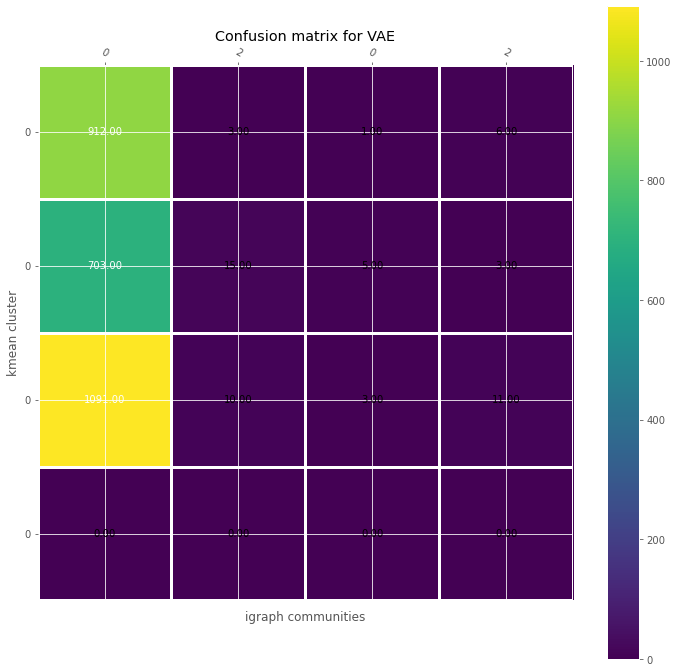

In [38]:
from sklearn.metrics import confusion_matrix
#import seaborn as sns

#s.set_context("paper")

labels = kmeans.labels_
community = list(sorted_community_labels.values())
kmeanclusters = list(sorted_kmeans_labels.values())

mat = confusion_matrix(community, kmeanclusters)
fig, ax = plt.subplots(figsize=(12,12))  

im, cbar = heatmap(mat.T, community, kmeanclusters, ax)
annotate_heatmap(im, mat.T)
plt.title('Confusion matrix for VAE')
plt.xlabel('igraph communities')
plt.ylabel('kmean cluster')

#im, cbar = heatmap(mat.T, community, kmeanclusters, square=False, annot=True, fmt='d', cbar=False, cmap="YlGnBu", ax=ax)

In [39]:
plt.savefig('CommMatrixVAE10epochsModel85.png')

<Figure size 432x288 with 0 Axes>

### Dimensionality Reduction and Visualization

In [40]:
import sys
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from sklearn import metrics 
from scipy.spatial.distance import cdist

from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
#import pandas as pd

from sklearn.metrics import confusion_matrix

In [41]:
community_labels = list(sorted_community_labels.values())
cluster_labels = list(sorted_kmeans_labels.values())

In [42]:
Counter(community_labels)

Counter({0: 2706, 1: 28, 3: 20, 2: 9})

In [43]:
Counter(cluster_labels)

Counter({0: 922, 2: 1115, 1: 726})

### 1. TSNE Manifold

In [44]:
X_embedded = TSNE(n_components=2).fit_transform(reshaped_latent_vectors)

Text(0.5, 1.0, 'TSNE with Cluster Labels')

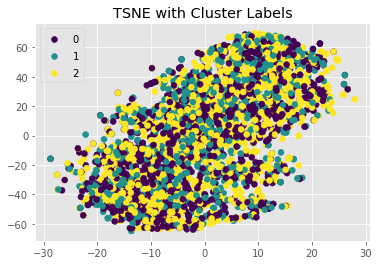

In [45]:
sc = plt.scatter(X_embedded[:,0], X_embedded[:,1], c = cluster_labels, label = cluster_labels)
plt.legend(*sc.legend_elements(), loc = 'best')
plt.title('TSNE with Cluster Labels')

Text(0.5, 1.0, 'TSNE with Community Detection Labels')

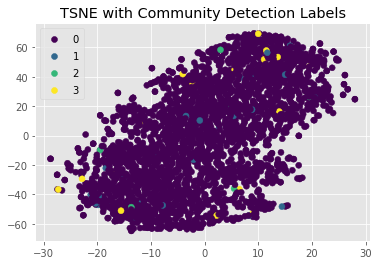

In [46]:
sc1 = plt.scatter(X_embedded[:,0], X_embedded[:,1], c = community_labels, label = community_labels)
plt.legend(*sc1.legend_elements(), loc = 'best')
plt.title('TSNE with Community Detection Labels')

### 2. Principle Component Analysis

In [47]:
pca = PCA(n_components = 3)
pca_result = pca.fit_transform(reshaped_latent_vectors)

In [48]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.4286888  0.07549093 0.04011968]


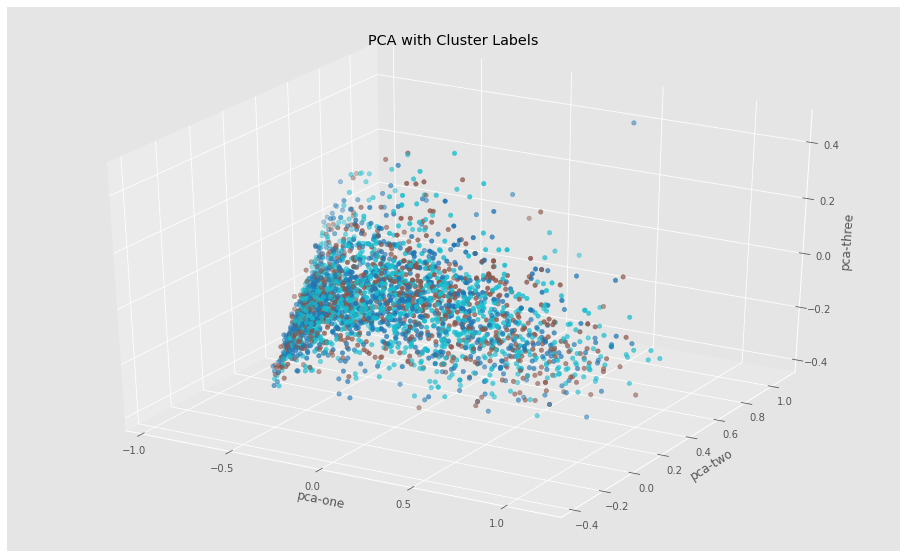

In [49]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:, 0], 
    ys=pca_result[:, 1], 
    zs=pca_result[:, 2], 
    c=cluster_labels, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
#plt.savefig('{}_pca_clusters.png'.format(save_name), dpi=300, bbox_inches='tight')
plt.title('PCA with Cluster Labels')
plt.show()

In [50]:
plt.savefig('PCA with Cluster Labels_Model85.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

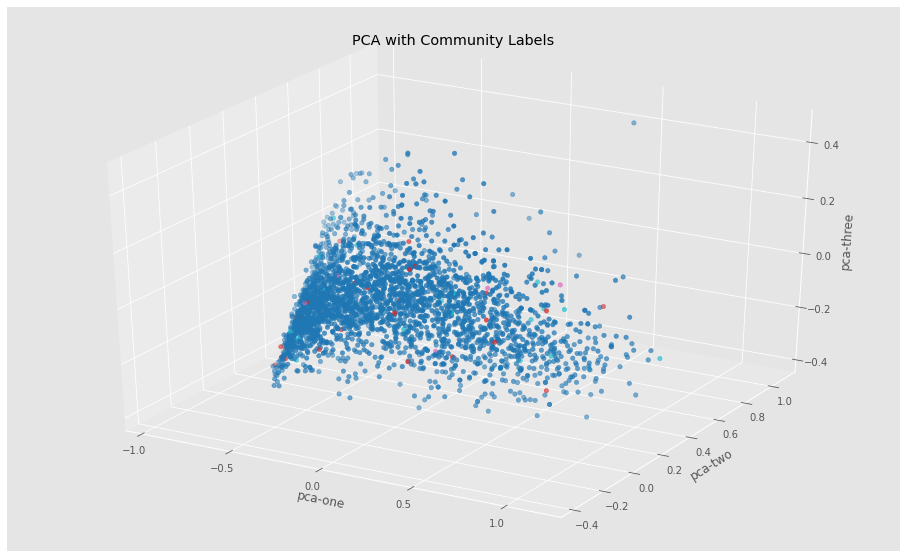

In [51]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:, 0], 
    ys=pca_result[:, 1], 
    zs=pca_result[:, 2], 
    c=community_labels, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
#plt.savefig('{}_pca_clusters.png'.format(save_name), dpi=300, bbox_inches='tight')
plt.title('PCA with Community Labels')
plt.show()

In [52]:
plt.savefig('PCA with Community Labels_Model85.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>